# Comparing linear regression and DFL-IO

Steps comparing the linear and inverse-DFL models:
1. Save two datasets
4. Split each dataset into train and test sets
5. Run DFL-IO with each training set, get weights $\theta^{\text{IO,close}}$ and $\theta^{\text{IO,wide}}$
6. Run linear regression on training set, get weights $\theta^{\text{R,close}}$ and $\theta^{\text{R,wide}}$
7. Compare all models on each training set, for each model:
    1. Predict demand using weights and features
    2. Solve MCFND with demand, get design variables $\hat{y}$
    3. Solve MCF-Flow with fixed design variables $\hat{y}$, get $\hat{x}$
    4. Compare costs of $\hat{y}, \hat{x}$ with optimal $x^*, y^*$ 

## Imports and configurations

In [1]:
using JuMP, Gurobi
using LinearAlgebra
using Distributions, Random, PDMats
using MLJ, Tables
using DataFrames, DataFramesMeta
using JLD, CSV
using PlotlyJS
using Pipe
using LaTeXStrings

Random.seed!(42)

TaskLocalRNG()

In [2]:
using Revise

includet("../models/forward.jl")
import .Forward as Forward

includet("../models/inversedemand.jl")
import .InverseDemand as IODemand

includet("../models/inverselinreg.jl")
import .InverseLinReg as IOLinReg

includet("../datagen/data-generation.jl")
import .DataGeneration as DataGen

In [3]:
Linear = @MLJ.load LinearRegressor pkg = "MLJLinearModels"
LAD = @MLJ.load LADRegressor pkg = "MLJLinearModels"

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/luca/.julia/packages/MLJModels/Ft0z9/src/loading.jl:159


import MLJLinearModels ✔


import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/luca/.julia/packages/MLJModels/Ft0z9/src/loading.jl:159


MLJLinearModels.LADRegressor

In [4]:
BASE_DATA_PATH = "../data/"
BASE_RESULTS_PATH = "../results/"

CLOSE_DATA_NAME = "close"
WIDE_DATA_NAME = "wide"

function dataset_path(n_points)
    return joinpath(BASE_DATA_PATH, "data_$n_points.jld") 
end

function results_path(n_points)
    return joinpath(BASE_RESULTS_PATH, "results_$n_points.csv")
end

results_path (generic function with 1 method)

## Problem parameters

Make a smaller problem with 1 commodity and 2 possible arcs, one low-ish capacity ($C$) and one high ($\infty$)


In [5]:
forward_params = Forward.Params(
    n_paths=2, 
    n_commodities=1,
    capacities=[100, 100000],
    design_costs=[10, 100],
    flow_costs=[10 100]',
    enabled_flows=ones(Bool, (2, 1))
)

datagen_params = DataGen.DataGenParams(
    weights=[1.5 -3 2], 
    noise_variance=[5.0^2]
)

inverse_params = IOLinReg.Params(
    n_features=datagen_params.n_features, 
    forward_params=forward_params, 
    with_noise=true,
    norm=IOLinReg.L2
)

Main.InverseLinReg.Params(3, 1, Main.Forward.Params(2, 1, Number[100, 100000], [10, 100], [10; 100;;], Bool[1; 1;;]), true, Main.InverseLinReg.L2)

## Data generation

Generate two datasets using fixed weights $\Theta$:
- $\mathcal{D}_{\text{close}}$ with $\mathbb{E}[d] = C$ 
- $\mathcal{D}_{\text{wide}}$ with $\mathbb{E}[d] \ll C$. 

Procedure for each data point in the dataset:
1. Draw $\phi_1, \ldots, \phi_{m-1} \sim U(a, b)$ for some $a, b$
2. Set $\phi_m$ such that $\sum_{i=1}^m \theta_i \phi_i = \mathbb{E}[d]$
3. Draw noise $\epsilon \sim \mathcal{N}(0, \sigma^2)$ and compute $d = \sum_{i=1}^m \theta_i \phi_i + \epsilon$
4. Solve MCFND for $d$ 
5. Datapoint $(\phi, d, x^*, y^*) \in \mathcal{D}$

Repeat dataset creation for several number of points


In [6]:
n_points = [3000]
close_target_demand = 100
wide_target_demand = 20

gurobi_env = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-23


Gurobi.Env(Ptr{Nothing} @0x0000000009da4760, false, 0)

In [7]:
regenerate = true

if regenerate
    for n in n_points
        close_dataset = DataGen.generate_dataset(forward_params, datagen_params, n_points=n, target_demand=close_target_demand, gurobi_env=gurobi_env)
        wide_dataset = DataGen.generate_dataset(forward_params, datagen_params, n_points=n, target_demand=wide_target_demand, gurobi_env=gurobi_env)

        save(dataset_path(n), CLOSE_DATA_NAME, close_dataset, WIDE_DATA_NAME, wide_dataset, compress=true)
    end
end

## Model training

Define a training function and a prediction function for each model:
- `train_{model_type}_model` takes in a training dataset of `IOLinReg.SolutionPoint`s, and returns a trained model
- `predict_{model_type}_model` takes a model of the correct type and a test dataset of `IOLinReg.SolutionPoint`s, and returns a vector of predicted demands

Utility functions

In [8]:
function load_dataset(n_points)
    dataset = JLD.load(dataset_path(n_points))

    return dataset[CLOSE_DATA_NAME], dataset[WIDE_DATA_NAME]
end

function convert_dataset_to_mlj(dataset)
    features = DataFrame(vcat(map(sol -> sol.linreg_features', dataset)...), :auto)
    demands = vcat(map(sol -> sol.actual_demands, dataset)...)

    return features, demands
end

convert_dataset_to_mlj (generic function with 1 method)

DFL-IO model training and prediction functions

In [9]:
function train_inverse_model(training_dataset)
    model = IOLinReg.create_problem(inverse_params, training_dataset, gurobi_env=gurobi_env)

    return IOLinReg.solve_problem!(model, inverse_params)
end

function predict_inverse_model(inverse_solution, test_dataset)
    features = map(row -> row.linreg_features, test_dataset)
    predict = f -> IOLinReg.predict_inverse_model(inverse_solution, f)

    return vcat(map(predict, features)...)
end

predict_inverse_model (generic function with 1 method)

Linear regression model training and prediction functions

In [10]:
function train_linear_model(training_dataset)
    features, demands = convert_dataset_to_mlj(training_dataset)

    # model = LAD(lambda=0.0, gamma=0.0)
    model = Linear(fit_intercept=false)
    mach = machine(model, features, demands)
    fit!(mach)

    return mach
end

function predict_linear_model(linreg_machine, test_dataset)
    features, _ = convert_dataset_to_mlj(test_dataset)
    return predict(linreg_machine, features)
end

predict_linear_model (generic function with 1 method)

## Model evaluation

Define an evaluation procedure `evaluate_model_on_dataset` as described in point 5 of the introduction. Takes a train and test dataset, and a training and prediction function for a given model.

In [11]:
function evaluate_model_on_dataset(train_data, test_data, train_model, make_predictions; gurobi_env=nothing)  
    trained_model = train_model(train_data)
    predicted_demands = make_predictions(trained_model, test_data)
    designed_network = compute_predicted_network_design(forward_params, predicted_demands, gurobi_env=gurobi_env)

    return compute_flow_problem_results(forward_params, test_data, designed_network, predicted_demands)
end

function compute_predicted_network_design(forward_params, predicted_demands; gurobi_env=nothing)
    solve_mcfnd = d -> Forward.create_and_solve_problem(forward_params, d, silent=true, gurobi_env=gurobi_env)
    return map(d -> solve_mcfnd(d).z_sol, predicted_demands) 
end

function compute_flow_problem_results(forward_params, test_dataset, predicted_z_sols, predicted_demands; gurobi_env=gurobi_env)
    actual_demands = map(row -> row.actual_demands, test_dataset)
    solve_flow = (d, z_sol) -> Forward.create_and_solve_flow_problem(forward_params, d, z_sol, silent=true, gurobi_env=gurobi_env)
    forward_solutions = map(solve_flow, actual_demands, predicted_z_sols)
    
    task_losses = map(sol -> sol.objective_value, forward_solutions)
    recourse_flow = map(sol -> sol.recourse_flow, forward_solutions)
    
    return DataFrame(
        task_loss=task_losses, 
        recourse_flow=recourse_flow, 
        predicted_demand=predicted_demands, 
        actual_demand=map(first, actual_demands)
    )
end

compute_flow_problem_results (generic function with 1 method)

### Model comparison pipeline and result cleaning

For a given full dataset of `n_points`, obtain the results of the DFL-IO and the Linear Regression model over the close and wide datasets

In [12]:
function compare_models(n_points; test_train_split=0.7)
    close_dataset, wide_dataset = load_dataset(n_points)
    dataset = vcat(close_dataset, wide_dataset)

    close_train, close_test = partition(close_dataset, test_train_split)
    wide_train, wide_test =  partition(wide_dataset, test_train_split)
    
    train = vcat(close_train, wide_train)
    test = vcat(close_test, wide_test)

    # close_io_results = evaluate_model_on_dataset(close_train, close_test, train_inverse_model, predict_inverse_model, gurobi_env=gurobi_env)
    # close_linreg_results = evaluate_model_on_dataset(close_train, close_test, train_linear_model, predict_linear_model, gurobi_env=gurobi_env)
    # wide_io_results = evaluate_model_on_dataset(wide_train, wide_test, train_inverse_model, predict_inverse_model, gurobi_env=gurobi_env)
    # wide_linreg_results = evaluate_model_on_dataset(wide_train, wide_test, train_linear_model, predict_linear_model, gurobi_env=gurobi_env)

    io_results = evaluate_model_on_dataset(train, test, train_inverse_model, predict_inverse_model, gurobi_env=gurobi_env)
    linreg_results = evaluate_model_on_dataset(train, test, train_linear_model, predict_linear_model, gurobi_env=gurobi_env)


    return vcat(
        # specify_model_and_data(close_io_results, "close", "io"),
        # specify_model_and_data(close_linreg_results, "close", "ladreg"),
        # specify_model_and_data(wide_io_results, "wide", "io"),
        # specify_model_and_data(wide_linreg_results, "wide", "ladreg")
        specify_model_and_data(io_results, "all", "io"),
        specify_model_and_data(linreg_results, "all", "linreg")
    )
end


function specify_model_and_data(results_data, data_type, model_type)
    length = nrow(results_data)

    data_column = categorical(fill(data_type, length))
    model_column = categorical(fill(model_type, length))

    types_df = DataFrame(dataset=data_column, model=model_column)

    return hcat(results_data, types_df)
end

specify_model_and_data (generic function with 1 method)

Generating and storing the results

In [13]:
all_results = [n => compare_models(n) for n in n_points]

for (n, res) in all_results
    CSV.write(results_path(n), res)
end;

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8400 rows, 4203 columns and 33600 nonzeros
Model fingerprint: 0x75515f5d
Model has 4200 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-03, 6e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 4200 rows and 0 columns
Presolve time: 0.01s
Presolved: 4200 rows, 4203 columns, 16800 nonzeros
Presolved model has 4200 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 Free vars  : 4203
 AA' NZ     : 1.260e+04
 Factor NZ  : 1.681e+04 (roughly 4 MB of memory)
 Factor Ops : 6.721e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter  

┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
│   max_inner: Int64 200
└ @ MLJLinearModels /home/luca/.julia/packages/MLJLinearModels/zSQnL/src/mlj/interface.jl:27


In [14]:
combined_results = vcat([
    hcat(res, DataFrame(:n_points => fill(n, nrows(res))))
    for (n, res) in all_results
]...)

CSV.write(results_path("all"), combined_results)

"../results/results_all.csv"

## Analysis

In [15]:
function load_results(n_points)
    results = CSV.read(results_path(n_points), DataFrame)

    if "n_points" ∉ names(results)
        @transform!(results, :n_points = fill("$n_points", nrow(results)))
    end

    @transform!(results, :dataset = categorical(:dataset))
    @transform!(results, :model = categorical(:model))
    @transform!(results, :n_points = string.(:n_points))

    return results
end

results = load_results("all")
subresults = [n => load_results(n) for n in n_points]

first(results, 5)

Row,task_loss,recourse_flow,predicted_demand,actual_demand,dataset,model,n_points
,Float64,Float64,Float64,Float64,Cat…,Cat…,String
1,1091.89,0.0,100.012,98.1893,all,io,3000
2,1490.73,0.0,100.131,103.807,all,io,3000
3,1614.94,0.0,100.114,105.049,all,io,3000
4,1517.5,0.0,100.138,104.075,all,io,3000
5,1345.93,0.0,100.035,102.359,all,io,3000


### Recouse paths and model robustness

No point in the wide dataset ever uses recourse flow, so we filter that dataset out

In [16]:
results[results.recourse_flow .> 0, :]

Row,task_loss,recourse_flow,predicted_demand,actual_demand,dataset,model,n_points
,Float64,Float64,Float64,Float64,Cat…,Cat…,String
1,2.62226e9,2.62226,99.98,102.622,all,io,3000
2,5.19623e9,5.19623,99.992,105.196,all,io,3000
3,4.45193e9,4.45193,99.9458,104.452,all,io,3000
4,4.63562e9,4.63562,99.971,104.636,all,io,3000
5,1.99983e9,1.99983,99.9445,102.0,all,io,3000
6,8.26554e9,8.26553,99.9683,108.266,all,io,3000
7,5.03795e9,5.03795,99.9724,105.038,all,io,3000
8,3.4816e9,3.4816,99.9605,103.482,all,io,3000
9,2.74274e9,2.74274,99.9967,102.743,all,io,3000


In [17]:
function analyze_n_recourse(res)
    return @chain res begin 
        groupby([:n_points, :dataset, :model])
        subset(:dataset => d -> d .!= "wide", ungroup=false)
        combine(:recourse_flow => (r -> count(x -> x .> 0, r)) => :n_recourse,
                :recourse_flow => (r -> count(x -> x .> 0, r) / nrows(r)) => :frac_recourse,
                :recourse_flow => mean)
        sort(:n_points, by=n -> parse(Int, n))
        @transform(:pct_recourse = 100 .* :frac_recourse)
        @transform(:str_pct_recourse = string.(round.(:pct_recourse, digits=1), "%"))
    end
end

recourse_analysis = analyze_n_recourse(results)

Row,n_points,dataset,model,n_recourse,frac_recourse,recourse_flow_mean,pct_recourse,str_pct_recourse
,String,Cat…,Cat…,Int64,Float64,Float64,Float64,String
1,3000,all,io,78,0.0433333,0.160993,4.33333,4.3%
2,3000,all,linreg,78,0.0433333,0.160993,4.33333,4.3%


First analyse, for every model and dataset, how many predicted demands result in having to use the recourse path. We are testing the robustness of the prediction algorithm

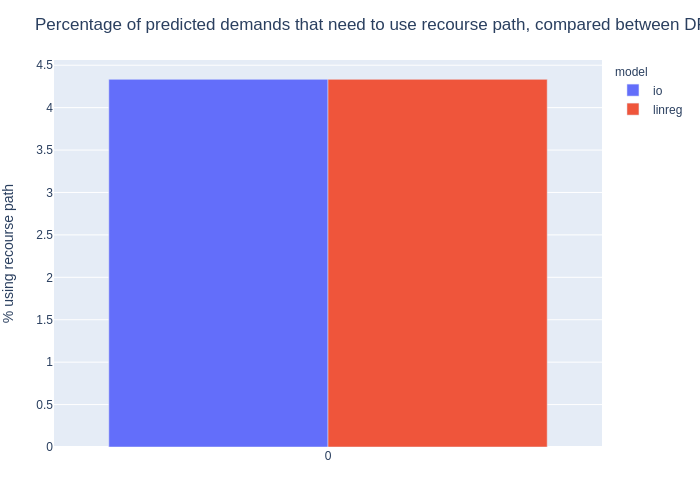

In [18]:
plot(
    recourse_analysis,
    kind="bar",
    y=:pct_recourse,
    text=:str_pct_recourse,
    facet_col=:n_points, 
    color=:model,
    Layout(
        xaxis_title="",
        yaxis_title="% using recourse path",
        title="Percentage of predicted demands that need to use recourse path, compared between DFL-IO and LAD Regression"
    )
)

We then look at the distribution of the flow over the recourse path for each model

In [19]:
all_recourses = @chain results begin
    subset(:recourse_flow => f -> f .> 0)
    subset(:dataset => d -> d .!= "wide")
end

first(all_recourses, 5)

Row,task_loss,recourse_flow,predicted_demand,actual_demand,dataset,model,n_points
,Float64,Float64,Float64,Float64,Cat…,Cat…,String
1,2.62226e9,2.62226,99.98,102.622,all,io,3000
2,5.19623e9,5.19623,99.992,105.196,all,io,3000
3,4.45193e9,4.45193,99.9458,104.452,all,io,3000
4,4.63562e9,4.63562,99.971,104.636,all,io,3000
5,1.99983e9,1.99983,99.9445,102.0,all,io,3000


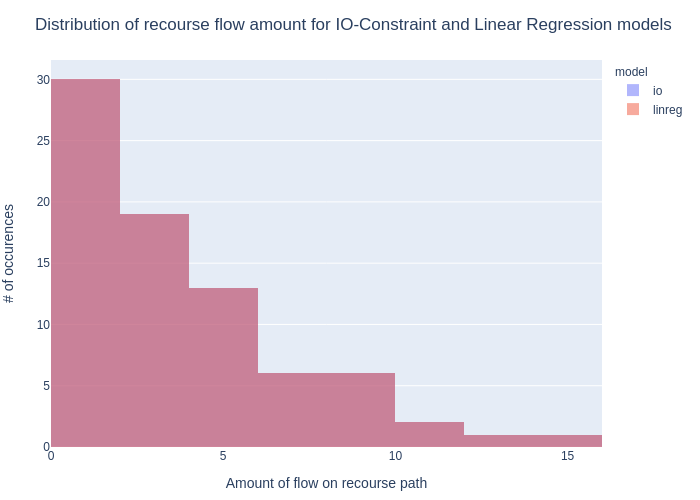

In [20]:
plot(
    all_recourses,
    kind="histogram",
    x=:recourse_flow,
    facet_col=:n_points, 
    color=:model,
    opacity=0.5,
    Layout(
        xaxis_title="Amount of flow on recourse path",
        yaxis_title="# of occurences",
        title="Distribution of recourse flow amount for IO-Constraint and Linear Regression models",
        barmode="overlay",
        width=500
    )
)

### Task losses

In [21]:
@chain results begin
    subset(:recourse_flow => r -> r .<= 0)
    groupby([:n_points, :dataset, :model])
    combine(:task_loss => (x -> [(mean(x), median(x), extrema(x)...)]) => [:mean, :median, :min, :max])
end

Row,n_points,dataset,model,mean,median,min,max
,String,Cat…,Cat…,Float64,Float64,Float64,Float64
1,3000,all,io,714.466,290.4,12.6773,3053.66
2,3000,all,linreg,714.466,290.4,12.6773,3053.66


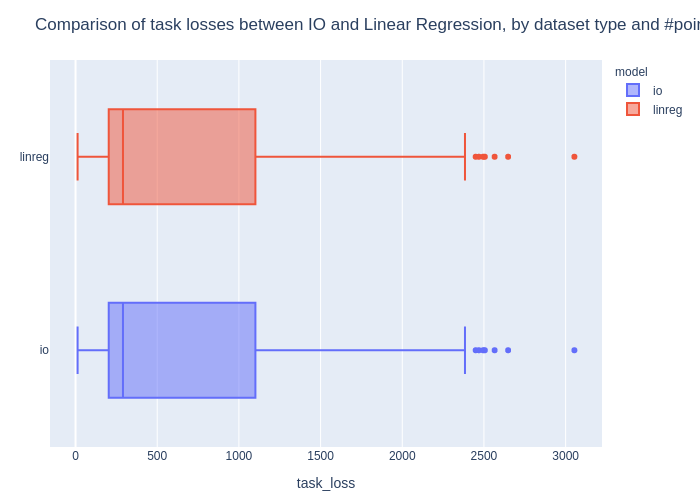

In [22]:
plot(
    subset(results, :recourse_flow => r -> r .<= 0),
    kind="box",
    x=:task_loss,
    facet_row=:n_points,
    facet_col=:dataset,
    color=:model,
    Layout(
        title="Comparison of task losses between IO and Linear Regression, by dataset type and #points",
        #xaxis_title="task_loss"
    )
)

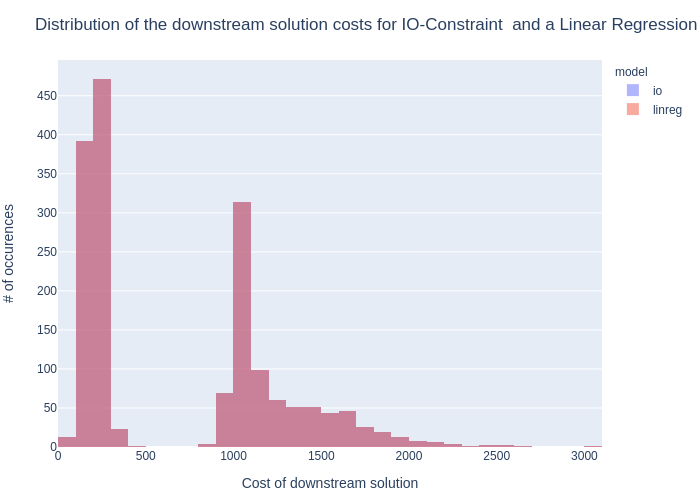

In [23]:
function plot_task_loss_distributions(results, dataset)
    no_recourse_results = @chain results begin
        subset(:recourse_flow => r -> r .<= 0)
        subset(:dataset => d -> d .== dataset)
    end
    
    return plot(
        no_recourse_results,
        kind="histogram",
        x=:task_loss,
        facet_row=:n_points, 
        color=:model,
        opacity=0.5,
        Layout(
            xaxis_title="Cost of downstream solution",
            yaxis_title="# of occurences",
            title="Distribution of the downstream solution costs for IO-Constraint \nand a Linear Regression (n_points=3000)",
            barmode="overlay",
            # height="1000",
            #width="500"
        )
    )
end

plot_task_loss_distributions(results, "all")

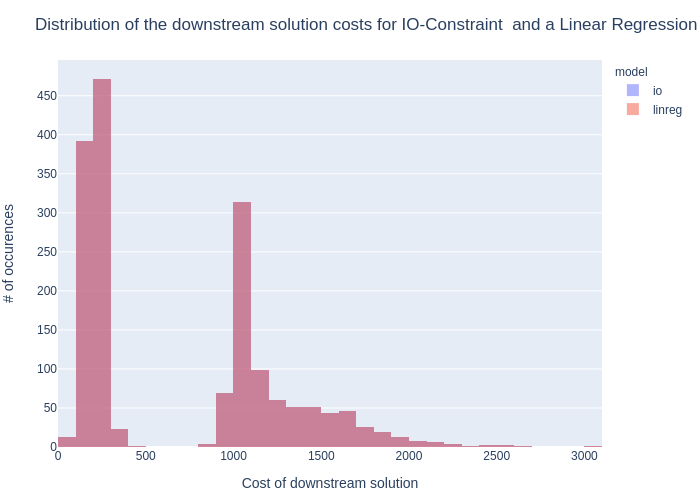

In [24]:
plot_task_loss_distributions(results, "all")

### Comparison of predicted demands

In [25]:
pred_io = @chain results begin
    subset(:model => m -> m .== "io")
    @rename(:pred_io = :predicted_demand, :recourse_io = :recourse_flow)
    select(:dataset, :n_points, :pred_io, :recourse_io)
end 

pred_linreg = @chain results begin
    subset(:model => m -> m .== "linreg")
    @rename(:pred_linreg = :predicted_demand, :recourse_linreg = :recourse_flow)
    select(:pred_linreg, :recourse_linreg)
end

pred_compared = hcat(pred_io, pred_linreg)

first(pred_compared, 5)

Row,dataset,n_points,pred_io,recourse_io,pred_linreg,recourse_linreg
,Cat…,String,Float64,Float64,Float64,Float64
1,all,3000,100.012,0.0,100.012,0.0
2,all,3000,100.131,0.0,100.131,0.0
3,all,3000,100.114,0.0,100.114,0.0
4,all,3000,100.138,0.0,100.138,0.0
5,all,3000,100.035,0.0,100.035,0.0


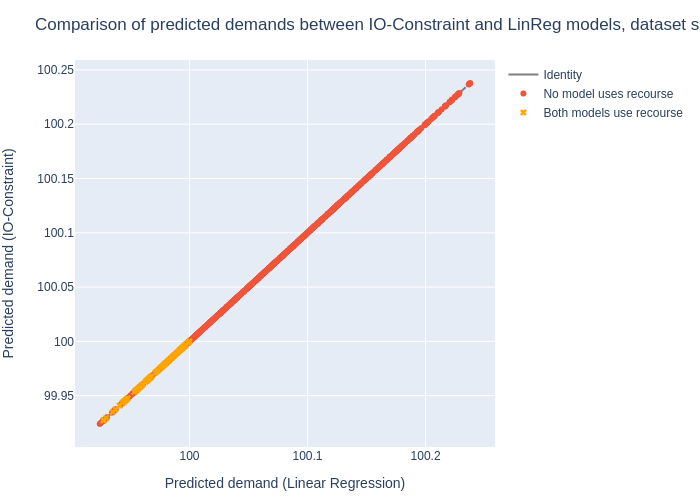

In [47]:
function categorise_compared_recourse(recourse_flow_io, recourse_flow_linreg)
    if recourse_flow_io .> 0 && recourse_flow_linreg .> 0
        return "both"
    elseif recourse_flow_io .> 0
        return "io"
    elseif recourse_flow_linreg > 0
        return "linreg"
    end
    
    return "none"
end

function plot_prediction_comparison(pred_compared, n_points, dataset)
    filtered = @chain pred_compared begin
        @subset(:n_points .== "$n_points")
        @subset(:dataset .== dataset)
        @subset(:pred_io .> 40)
        @transform(@byrow :recourse_use = categorise_compared_recourse(:recourse_io, :recourse_linreg))
    end

    mn, mx = extrema(vcat(filtered.pred_io, filtered.pred_linreg))
    t = mn:0.01:mx

    return plot(
        [
            scatter(x=t, y=t, mode="lines", name="Identity", line_color="gray"),
            scatter(filtered[filtered.recourse_use .== "none", :], x=:pred_linreg, y=:pred_io, marker_color="blue", mode="markers", name="No model uses recourse"),
            scatter(filtered[filtered.recourse_use .== "io", :], x=:pred_linreg, y=:pred_io, mode="markers", name="Only DFL-IO uses recourse"),
            scatter(filtered[filtered.recourse_use .== "both", :], x=:pred_linreg, y=:pred_io, marker_color="orange", marker_symbol="x", mode="markers", name="Both models use recourse"),
            scatter(filtered[filtered.recourse_use .== "linreg", :], x=:pred_linreg, y=:pred_io, mode="markers", name="Only LinReg uses recourse"),
        ],
        Layout(
            xaxis_title="Predicted demand (Linear Regression)",
            yaxis_title="Predicted demand (IO-Constraint)",
            title="Comparison of predicted demands between IO-Constraint and LinReg models, dataset size = $n_points"
        )
    )
end

plot_prediction_comparison(pred_compared, 3000, "all")

In [27]:
plot_prediction_comparison(pred_compared, 1000, "all")

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [28]:
plot_prediction_comparison(pred_compared, 3000, "close")

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [29]:
plot_prediction_comparison(pred_compared, 10000, "close")

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [30]:
plot_prediction_comparison(pred_compared, 100, "wide")

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [31]:
plot_prediction_comparison(pred_compared, 1000, "wide")

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [32]:
plot_prediction_comparison(pred_compared, 3000, "wide")

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [33]:
plot_prediction_comparison(pred_compared, 10000, "wide")

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer